<a href="https://colab.research.google.com/github/Carvalho-Andre/analise_simulacoes_doutorado/blob/main/4Chan_Screenshot_OCR_Processo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ═══════════════════════════════════════════════════════════
# CÉLULA 1: INSTALAÇÃO DE DEPENDÊNCIAS
# ═══════════════════════════════════════════════════════════

print("🔧 Instalando dependências...")

# Instala Tesseract OCR
!apt-get install -y tesseract-ocr
!apt-get install -y libtesseract-dev

# Instala bibliotecas Python
!pip install pytesseract pillow pandas openpyxl

print("✅ Instalação concluída!")

🔧 Instalando dependências...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev
0 upgraded, 3 newly installed, 0 to remove and 2 not upgraded.
Need to get 3,743 kB of archives.
After this operation, 16.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1.5 [581 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleptonica-dev amd64 1.82.0-3build1 [1,562 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libtesseract-dev amd6

In [3]:
# ═══════════════════════════════════════════════════════════
# CÉLULA 2: MONTAR GOOGLE DRIVE E EXPLORAR ESTRUTURA
# ═══════════════════════════════════════════════════════════

from google.colab import drive
import os

# Monta o Google Drive
drive.mount('/content/drive')

print("✅ Google Drive montado com sucesso!\n")

# Vamos explorar a estrutura para encontrar a pasta correta
print("📁 Explorando estrutura do Drive...\n")

# Lista pastas principais
print("=" * 60)
print("PASTAS NO DRIVE RAIZ:")
print("=" * 60)
mydrive_path = '/content/drive/MyDrive'
for item in sorted(os.listdir(mydrive_path))[:20]:
    full_path = os.path.join(mydrive_path, item)
    tipo = "📁 PASTA" if os.path.isdir(full_path) else "📄 ARQUIVO"
    print(f"{tipo}: {item}")

print("\n" + "=" * 60)
print("PROCURANDO PASTA DE PESQUISA...")
print("=" * 60)

# Procura pela pasta de pesquisa
research_folder = None
for item in os.listdir(mydrive_path):
    if 'pesquisa' in item.lower() and '4chan' in item.lower():
        research_folder = os.path.join(mydrive_path, item)
        print(f"✅ ENCONTRADA: {item}")
        break

if not research_folder:
    print("❌ Pasta de pesquisa não encontrada!")
    print("\n💡 Por favor, digite o nome EXATO da pasta:")
    print("   (copie e cole da lista acima)")
else:
    print(f"\n📁 Caminho completo: {research_folder}")

    # Explora conteúdo da pasta de pesquisa
    print("\n" + "=" * 60)
    print("CONTEÚDO DA PASTA DE PESQUISA:")
    print("=" * 60)
    for item in sorted(os.listdir(research_folder)):
        full_path = os.path.join(research_folder, item)
        tipo = "📁 PASTA" if os.path.isdir(full_path) else "📄 ARQUIVO"
        print(f"{tipo}: {item}")

    # Procura pasta 4Chan
    chan_folder = os.path.join(research_folder, '4Chan')
    if os.path.exists(chan_folder):
        print("\n" + "=" * 60)
        print("CONTEÚDO DA PASTA 4CHAN:")
        print("=" * 60)
        for item in sorted(os.listdir(chan_folder)):
            full_path = os.path.join(chan_folder, item)
            tipo = "📁 PASTA" if os.path.isdir(full_path) else "📄 ARQUIVO"
            print(f"{tipo}: {item}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive montado com sucesso!

📁 Explorando estrutura do Drive...

PASTAS NO DRIVE RAIZ:
📄 ARQUIVO:   André Silva de Carvalho_V2.1.pdf
📄 ARQUIVO:  Projeto Inovação _ Administração.gform
📁 PASTA: Across
📁 PASTA: Ameaças Eletromagnéticas
📄 ARQUIVO: André Silva de Carvalho_V2.1.docx
📄 ARQUIVO: Apadrinhamento_Met_Taz_Jose+uma ajuda extra.pdf
📁 PASTA: Articles Généraux 
📁 PASTA: Articles PDESPM
📁 PASTA: BIBLIOGRAFIA
📁 PASTA: CAT
📁 PASTA: CAT + SMARTNX
📄 ARQUIVO: Carta de interesse_Grupo de Estudo - Lucia Santaella - IEA-USP.pdf
📁 PASTA: Colab Notebooks
📄 ARQUIVO: Cours de Français 2026 (1).gdoc
📄 ARQUIVO: Cours de Français 2026.gdoc
📄 ARQUIVO: Cópia de  Projeto Inovação _ Engenharia Produção .gform
📄 ARQUIVO: Cópia de Projeto APP de Busca de Dados em Redes Sociais (1).gslides
📄 ARQUIVO: Cópia de Projeto APP de Busca de Dados em Redes Socia

In [4]:
# ═══════════════════════════════════════════════════════════
# CÉLULA 3: CLASSE PROCESSADORA DE SCREENSHOTS
# ═══════════════════════════════════════════════════════════

import re
from datetime import datetime
from pathlib import Path
import pandas as pd
from PIL import Image
import pytesseract

class FourChanScreenshotProcessor:
    """Processa screenshots do 4Chan extraindo texto via OCR"""

    def __init__(self, output_dir):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True, parents=True)
        self.results = []
        self.user_mapping = {}
        self.user_counter = 1
        self.ocr_errors = []

    def anonymize_user(self, username):
        """Converte username real em User_XXX"""
        if not username or username.strip() == '':
            username = 'Anonymous'

        if username not in self.user_mapping:
            self.user_mapping[username] = f"User_{self.user_counter:03d}"
            self.user_counter += 1
        return self.user_mapping[username]

    def extract_metadata_from_filename(self, filename):
        """Extrai metadados do nome do arquivo"""
        # Padrão: 4chan_pol_1.png
        match = re.match(r'4chan_([^_]+)_(\d+)', filename)
        if match:
            board = match.group(1)
            sequence = match.group(2)
            return {
                'board': f"/{board}/",
                'sequence': int(sequence),
                'screenshot_id': filename
            }
        return {
            'board': '/pol/',
            'sequence': 0,
            'screenshot_id': filename
        }

    def process_image(self, image_path):
        """Processa uma imagem com OCR"""
        try:
            # Abre imagem
            img = Image.open(image_path)

            # OCR com Tesseract (config otimizado para screenshots)
            custom_config = r'--oem 3 --psm 6'
            text = pytesseract.image_to_string(img, config=custom_config)

            # Extrai metadados do filename
            metadata = self.extract_metadata_from_filename(Path(image_path).name)

            # Processa texto
            lines = [line.strip() for line in text.split('\n') if line.strip()]

            # Tenta identificar posts
            posts = self.parse_posts(lines)

            # Se não encontrou posts, cria um genérico
            if not posts:
                posts = [{
                    'user': 'User_000',
                    'post_number': None,
                    'text_content': text.strip(),
                    'timestamp': None,
                    'has_image': False,
                    'reply_to': None
                }]

            # Adiciona metadados a cada post
            for post in posts:
                post.update(metadata)
                post['char_count'] = len(post['text_content'])
                post['word_count'] = len(post['text_content'].split())
                post['processing_date'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

            self.results.extend(posts)

            return {
                'success': True,
                'image': Path(image_path).name,
                'posts_found': len(posts),
                'char_count': len(text),
                'ocr_confidence': 'high' if len(text) > 50 else 'low'
            }

        except Exception as e:
            self.ocr_errors.append({
                'image': Path(image_path).name,
                'error': str(e)
            })
            return {
                'success': False,
                'image': Path(image_path).name,
                'error': str(e)
            }

    def parse_posts(self, lines):
        """Parse de posts do 4Chan com melhor detecção"""
        posts = []
        current_post = None

        for i, line in enumerate(lines):
            # Detecta início de post
            # Padrões: "Anonymous", "No.XXXXX", datas
            is_header = any([
                'Anonymous' in line,
                re.search(r'No\.\s*\d+', line),
                re.search(r'\d{2}/\d{2}/\d{2,4}', line)
            ])

            if is_header:
                # Salva post anterior
                if current_post and current_post['text_content'].strip():
                    posts.append(current_post)

                # Extrai informações do header
                post_match = re.search(r'No\.\s*(\d+)', line)
                post_num = post_match.group(1) if post_match else None

                timestamp = self.extract_timestamp(line)

                # Detecta se é reply
                reply_match = re.search(r'>>(\d+)', line)
                reply_to = reply_match.group(1) if reply_match else None

                current_post = {
                    'user': self.anonymize_user('Anonymous'),
                    'post_number': post_num,
                    'text_content': '',
                    'timestamp': timestamp,
                    'has_image': '[IMG]' in line or 'File:' in line,
                    'reply_to': reply_to
                }
            elif current_post is not None:
                # Adiciona linha ao conteúdo
                if line and not line.startswith('>>'):  # Ignora links de reply isolados
                    current_post['text_content'] += line + ' '

        # Adiciona último post
        if current_post and current_post['text_content'].strip():
            posts.append(current_post)

        return posts

    def extract_timestamp(self, text):
        """Extrai timestamp do texto"""
        patterns = [
            r'\d{2}/\d{2}/\d{2}\([A-Za-z]+\)\d{2}:\d{2}:\d{2}',
            r'\d{2}/\d{2}/\d{4}\s+\d{2}:\d{2}:\d{2}',
            r'\d{2}/\d{2}/\d{2}\s+\d{2}:\d{2}',
        ]
        for pattern in patterns:
            match = re.search(pattern, text)
            if match:
                return match.group(0)
        return None

    def process_batch(self, image_paths, max_images=None):
        """Processa lote de imagens"""
        if max_images:
            image_paths = image_paths[:max_images]

        results = []
        total = len(image_paths)

        print(f"🔄 Processando {total} screenshots...")
        print("=" * 60)

        for i, img_path in enumerate(image_paths, 1):
            print(f"\n[{i}/{total}] {Path(img_path).name}...", end=' ')
            result = self.process_image(img_path)
            results.append(result)

            if result['success']:
                print(f"✅ {result['posts_found']} posts ({result['char_count']} chars)")
            else:
                print(f"❌ ERRO")

        return results

    def save_to_csv(self, filename="4chan_pol_processed.csv"):
        """Salva resultados em CSV"""
        if not self.results:
            print("⚠️ Nenhum dado para salvar")
            return None

        df = pd.DataFrame(self.results)

        # Reordena colunas
        columns = [
            'screenshot_id', 'board', 'sequence',
            'user', 'post_number', 'timestamp',
            'reply_to', 'has_image',
            'text_content',
            'char_count', 'word_count',
            'processing_date'
        ]

        columns = [col for col in columns if col in df.columns]
        df = df[columns]

        # Salva CSV
        csv_path = self.output_dir / filename
        df.to_csv(csv_path, index=False, encoding='utf-8')

        # Salva Excel também
        excel_path = self.output_dir / filename.replace('.csv', '.xlsx')
        df.to_excel(excel_path, index=False, engine='openpyxl')

        print(f"\n💾 CSV salvo em: {csv_path}")
        print(f"💾 Excel salvo em: {excel_path}")

        return csv_path

    def generate_report(self):
        """Gera relatório completo"""
        if not self.results:
            return "⚠️ Nenhum dado processado"

        df = pd.DataFrame(self.results)

        # Calcula métricas de qualidade
        posts_with_timestamp = df['timestamp'].notna().sum()
        posts_with_number = df['post_number'].notna().sum()
        posts_with_content = (df['text_content'].str.len() > 10).sum()

        report = f"""
╔══════════════════════════════════════════════════════════╗
║        RELATÓRIO DE PROCESSAMENTO OCR - 4CHAN /pol/      ║
╚══════════════════════════════════════════════════════════╝

📊 ESTATÍSTICAS GERAIS:
   • Screenshots processados: {df['screenshot_id'].nunique()}
   • Posts extraídos: {len(df)}
   • Usuários únicos identificados: {df['user'].nunique()}
   • Posts com imagem: {df['has_image'].sum() if 'has_image' in df else 0}
   • Replies (respostas): {df['reply_to'].notna().sum() if 'reply_to' in df else 0}

📝 ANÁLISE DE TEXTO:
   • Total de caracteres: {df['char_count'].sum():,}
   • Média por post: {df['char_count'].mean():.1f} caracteres
   • Mediana: {df['char_count'].median():.1f} caracteres
   • Post mais longo: {df['char_count'].max()} caracteres
   • Post mais curto: {df['char_count'].min()} caracteres
   • Total de palavras: {df['word_count'].sum():,}

👥 ANONIMIZAÇÃO:
   • Usuários mapeados: {len(self.user_mapping)}
   • Formato: User_001, User_002, User_003...
   • Todos os "Anonymous" convertidos

✅ QUALIDADE DOS DADOS (para Metodologia):
   • Posts com timestamp: {posts_with_timestamp} ({posts_with_timestamp/len(df)*100:.1f}%)
   • Posts com número: {posts_with_number} ({posts_with_number/len(df)*100:.1f}%)
   • Posts com conteúdo (>10 chars): {posts_with_content} ({posts_with_content/len(df)*100:.1f}%)
   • Taxa de sucesso OCR: {(1 - len(self.ocr_errors)/df['screenshot_id'].nunique())*100:.1f}%

⚠️ ERROS DE PROCESSAMENTO:
   • Screenshots com erro: {len(self.ocr_errors)}
   {chr(10).join([f"   - {e['image']}: {e['error']}" for e in self.ocr_errors[:5]])}

📈 DISTRIBUIÇÃO POR SCREENSHOT:
"""
        # Adiciona estatísticas por screenshot
        by_screenshot = df.groupby('screenshot_id').agg({
            'post_number': 'count',
            'char_count': 'sum'
        }).rename(columns={'post_number': 'posts', 'char_count': 'total_chars'})

        report += by_screenshot.to_string()

        return report

    def save_validation_sample(self, n=5):
        """Salva amostra para validação manual"""
        if not self.results:
            return

        df = pd.DataFrame(self.results)
        sample = df.sample(min(n, len(df)))

        validation_path = self.output_dir / "validation_sample.csv"
        sample.to_csv(validation_path, index=False, encoding='utf-8')

        print(f"📋 Amostra de validação salva: {validation_path}")
        print(f"   Use para validar acurácia do OCR manualmente!")

print("✅ Classe processadora carregada!")

✅ Classe processadora carregada!


In [9]:
# ═══════════════════════════════════════════════════════════
# CÉLULA SIMPLIFICADA: CAMINHO MANUAL
# ═══════════════════════════════════════════════════════════

import os
from google.colab import drive

print("🚀 SETUP COM CAMINHO MANUAL\n")

# ──────────────────────────────────────────────────────────
# 1. MONTA DRIVE
# ──────────────────────────────────────────────────────────
try:
    os.listdir('/content/drive/MyDrive')
    print("✅ Drive já montado\n")
except:
    drive.mount('/content/drive')
    print("✅ Drive montado!\n")

# ──────────────────────────────────────────────────────────
# 2. LISTA PASTAS PARA VOCÊ ESCOLHER
# ──────────────────────────────────────────────────────────

print("=" * 60)
print("📁 TODAS AS PASTAS NO SEU GOOGLE DRIVE:")
print("=" * 60)

BASE_PATH = '/content/drive/MyDrive'
pastas = sorted([f for f in os.listdir(BASE_PATH) if os.path.isdir(os.path.join(BASE_PATH, f))])

for i, pasta in enumerate(pastas, 1):
    print(f"{i:3d}. {pasta}")

print("\n" + "=" * 60)
print("👆 ENCONTRE O NOME EXATO DA PASTA DE PESQUISA ACIMA")
print("=" * 60)

# ──────────────────────────────────────────────────────────
# 3. DEFINA O CAMINHO MANUALMENTE AQUI 👇
# ──────────────────────────────────────────────────────────

# COLE AQUI O NOME EXATO DA PASTA (copie da lista acima)
NOME_PASTA_PESQUISA = 'Pesquisa 4Chan, Reddit e Discord'  # 👈 EDITE AQUI!

# ──────────────────────────────────────────────────────────
# 4. CONSTRÓI CAMINHOS COMPLETOS
# ───────────────────────────────────────────────

🚀 SETUP COM CAMINHO MANUAL

✅ Drive já montado

📁 TODAS AS PASTAS NO SEU GOOGLE DRIVE:
  1. Across
  2. Ameaças Eletromagnéticas
  3. Articles Généraux 
  4. Articles PDESPM
  5. BIBLIOGRAFIA
  6. CAT
  7. CAT + SMARTNX
  8. Colab Notebooks
  9. DOCUMENTOS
 10. DOUTORADO André Carvalho
 11. Distrito => Sem Parar 
 12. FB
 13. FEI
 14. FEI - ARTIGO ELIANA 
 15. FEI_DeepTech
 16. Français
 17. Français Del A2
 18. INSTA
 19. Intermédiaire
 20. Linguagem R
 21. MADONNA
 22. MBA AVANADE
 23. MOSAIC CAT
 24. Metodologia de Pesquisa
 25. Método de Pesquisa
 26. PESQUISA AMEAÇAS ELETROMAGNÉTICAS
 27. POC SINCRED 
 28. PROJETO PESSOALIZE
 29. Pesquisa 4Chan, Reddit e Discord
 30. Projeto HC
 31. TCC
 32. TCC OTIMIZAÇÃO ENTREGA - ENG PROD
 33. TCC PERSONA INFLUCENCIADORES _ NPB640_2022.1
 34. TCC PIX
 35. TIPOS DE PESQUISA CIENTÍFICA
 36. Tech Lab FEI
 37. TotalIP
 38. X
 39. XP
 40. iTrack + Madeira Madeira

👆 ENCONTRE O NOME EXATO DA PASTA DE PESQUISA ACIMA


In [14]:
# CÉLULA 5: PROCESSAR TODOS OS SCREENSHOTS
# Versão simplificada sem f-strings problemáticas

# CÉLULA DE DIAGNÓSTICO - ENCONTRAR CAMINHO CORRETO

import os

print("EXPLORANDO GOOGLE DRIVE")
print("=" * 60)

base = "/content/drive/MyDrive"

# 1. Lista todas as pastas principais
print("\n1. PASTAS NO MYDRIVE:")
print("-" * 60)
pastas_principais = []
for item in sorted(os.listdir(base)):
    caminho = os.path.join(base, item)
    if os.path.isdir(caminho):
        pastas_principais.append(item)
        print("   " + item)

# 2. Procura pasta de pesquisa
print("\n2. PROCURANDO PASTA DE PESQUISA...")
print("-" * 60)

pasta_pesquisa = None
for pasta in pastas_principais:
    if "pesquisa" in pasta.lower() or "4chan" in pasta.lower():
        pasta_pesquisa = pasta
        print("ENCONTRADA: " + pasta)
        break

if not pasta_pesquisa:
    print("NAO ENCONTRADA AUTOMATICAMENTE!")
    print("\nPor favor, copie o nome EXATO da pasta da lista acima")
    print("que contem os dados do 4Chan/Reddit/Discord")
else:
    # 3. Explora pasta de pesquisa
    caminho_pesquisa = os.path.join(base, pasta_pesquisa)
    print("\n3. CONTEUDO DA PASTA: " + pasta_pesquisa)
    print("-" * 60)

    conteudo_pesquisa = os.listdir(caminho_pesquisa)
    for item in sorted(conteudo_pesquisa):
        caminho_item = os.path.join(caminho_pesquisa, item)
        tipo = "[PASTA]" if os.path.isdir(caminho_item) else "[ARQUIVO]"
        print("   " + tipo + " " + item)

    # 4. Procura pasta 4Chan
    pasta_4chan = None
    for item in conteudo_pesquisa:
        if "4chan" in item.lower():
            pasta_4chan = item
            break

    if pasta_4chan:
        caminho_4chan = os.path.join(caminho_pesquisa, pasta_4chan)
        print("\n4. CONTEUDO DA PASTA: " + pasta_4chan)
        print("-" * 60)

        conteudo_4chan = os.listdir(caminho_4chan)
        for item in sorted(conteudo_4chan):
            caminho_item = os.path.join(caminho_4chan, item)
            tipo = "[PASTA]" if os.path.isdir(caminho_item) else "[ARQUIVO]"
            print("   " + tipo + " " + item)

        # 5. Procura pasta pol
        pasta_pol = None
        for item in conteudo_4chan:
            if "pol" in item.lower():
                pasta_pol = item
                print("\n5. ENCONTRADA PASTA POL: " + item)
                break

        if pasta_pol:
            caminho_pol = os.path.join(caminho_4chan, pasta_pol)

            # Verifica se existe
            if os.path.exists(caminho_pol):
                print("   Caminho verificado: OK")

                # Lista screenshots
                arquivos_pol = os.listdir(caminho_pol)
                pngs = [f for f in arquivos_pol if f.lower().endswith('.png')]

                print("\n6. SCREENSHOTS NA PASTA POL:")
                print("-" * 60)
                print("   Total de arquivos: " + str(len(arquivos_pol)))
                print("   Arquivos PNG: " + str(len(pngs)))

                if len(pngs) > 0:
                    print("\n   Primeiros 5 PNGs:")
                    for i, png in enumerate(pngs[:5], 1):
                        print("      " + str(i) + ". " + png)

                # MOSTRA CAMINHO CORRETO
                print("\n" + "=" * 60)
                print("CAMINHO CORRETO PARA USAR:")
                print("=" * 60)
                print(caminho_pol)
                print("=" * 60)

                print("\nCOPIE O CAMINHO ACIMA E USE NA CELULA 5!")
            else:
                print("   ERRO: Caminho nao existe!")
        else:
            print("\n5. PASTA POL NAO ENCONTRADA!")
            print("   Pastas disponiveis em 4Chan:")
            for item in conteudo_4chan:
                if os.path.isdir(os.path.join(caminho_4chan, item)):
                    print("      - " + item)
    else:
        print("\n4. PASTA 4CHAN NAO ENCONTRADA!")

EXPLORANDO GOOGLE DRIVE

1. PASTAS NO MYDRIVE:
------------------------------------------------------------
   Across
   Ameaças Eletromagnéticas
   Articles Généraux 
   Articles PDESPM
   BIBLIOGRAFIA
   CAT
   CAT + SMARTNX
   Colab Notebooks
   DOCUMENTOS
   DOUTORADO André Carvalho
   Distrito => Sem Parar 
   FB
   FEI
   FEI - ARTIGO ELIANA 
   FEI_DeepTech
   Français
   Français Del A2
   INSTA
   Intermédiaire
   Linguagem R
   MADONNA
   MBA AVANADE
   MOSAIC CAT
   Metodologia de Pesquisa
   Método de Pesquisa
   PESQUISA AMEAÇAS ELETROMAGNÉTICAS
   POC SINCRED 
   PROJETO PESSOALIZE
   Pesquisa 4Chan, Reddit e Discord
   Projeto HC
   TCC
   TCC OTIMIZAÇÃO ENTREGA - ENG PROD
   TCC PERSONA INFLUCENCIADORES _ NPB640_2022.1
   TCC PIX
   TIPOS DE PESQUISA CIENTÍFICA
   Tech Lab FEI
   TotalIP
   X
   XP
   iTrack + Madeira Madeira

2. PROCURANDO PASTA DE PESQUISA...
------------------------------------------------------------
ENCONTRADA: Metodologia de Pesquisa

In [15]:
# DIAGNÓSTICO CORRIGIDO - PASTA ESPECÍFICA

import os

print("EXPLORANDO GOOGLE DRIVE")
print("=" * 60)

base = "/content/drive/MyDrive"

# Nome EXATO da pasta
NOME_PASTA = "Pesquisa 4Chan, Reddit e Discord"

caminho_pesquisa = os.path.join(base, NOME_PASTA)

# Verifica se existe
if not os.path.exists(caminho_pesquisa):
    print("ERRO: Pasta nao encontrada!")
    print("Procurado: " + caminho_pesquisa)
    raise FileNotFoundError("Pasta nao existe")

print("PASTA ENCONTRADA: " + NOME_PASTA)
print("")

# Lista conteúdo
print("CONTEUDO DA PASTA:")
print("-" * 60)
conteudo = os.listdir(caminho_pesquisa)
for item in sorted(conteudo):
    caminho_item = os.path.join(caminho_pesquisa, item)
    tipo = "[PASTA]" if os.path.isdir(caminho_item) else "[ARQUIVO]"
    print("   " + tipo + " " + item)

# Procura 4Chan
pasta_4chan = None
for item in conteudo:
    if "4chan" in item.lower():
        pasta_4chan = item
        break

if not pasta_4chan:
    print("\nERRO: Pasta 4Chan nao encontrada!")
    raise FileNotFoundError("4Chan nao existe")

caminho_4chan = os.path.join(caminho_pesquisa, pasta_4chan)
print("\n" + "=" * 60)
print("PASTA 4CHAN ENCONTRADA: " + pasta_4chan)
print("=" * 60)

# Lista boards
print("\nBOARDS DISPONIVEIS:")
print("-" * 60)
boards = os.listdir(caminho_4chan)
for board in sorted(boards):
    caminho_board = os.path.join(caminho_4chan, board)
    tipo = "[PASTA]" if os.path.isdir(caminho_board) else "[ARQUIVO]"
    print("   " + tipo + " " + board)

# Procura pol
pasta_pol = None
for board in boards:
    if "pol" in board.lower():
        pasta_pol = board
        break

if not pasta_pol:
    print("\nERRO: Pasta pol nao encontrada!")
    raise FileNotFoundError("pol nao existe")

caminho_pol = os.path.join(caminho_4chan, pasta_pol)
print("\n" + "=" * 60)
print("PASTA POL ENCONTRADA: " + pasta_pol)
print("=" * 60)

# Lista screenshots
print("\nSCREENSHOTS:")
print("-" * 60)
arquivos = os.listdir(caminho_pol)
pngs = sorted([f for f in arquivos if f.lower().endswith('.png')])

print("Total de arquivos: " + str(len(arquivos)))
print("Arquivos PNG: " + str(len(pngs)))

if len(pngs) > 0:
    print("\nPrimeiros 5 PNGs:")
    for i, png in enumerate(pngs[:5], 1):
        print("   " + str(i) + ". " + png)
    if len(pngs) > 5:
        print("   ... + " + str(len(pngs) - 5) + " arquivos")

# CAMINHO FINAL
print("\n" + "=" * 60)
print("CAMINHO COMPLETO CORRETO:")
print("=" * 60)
print(caminho_pol)
print("=" * 60)

print("\nCOPIE ESTE CAMINHO PARA A CELULA 5!")

EXPLORANDO GOOGLE DRIVE
PASTA ENCONTRADA: Pesquisa 4Chan, Reddit e Discord

CONTEUDO DA PASTA:
------------------------------------------------------------
   [PASTA] 4Chan
   [PASTA] Bibliografia
   [PASTA] Dados Processados
   [PASTA] Discord Server
   [PASTA] Pasta sem nome
   [ARQUIVO] Pesquisa.gdoc
   [PASTA] Reddit

PASTA 4CHAN ENCONTRADA: 4Chan

BOARDS DISPONIVEIS:
------------------------------------------------------------
   [PASTA]  b  – Random
   [PASTA]  news 
   [PASTA]  pol  – Politically Incorrect

PASTA POL ENCONTRADA:  pol  – Politically Incorrect

SCREENSHOTS:
------------------------------------------------------------
Total de arquivos: 17
Arquivos PNG: 17

Primeiros 5 PNGs:
   1. 4chan_pol_1.png
   2. 4chan_pol_10.png
   3. 4chan_pol_11.png
   4. 4chan_pol_12.png
   5. 4chan_pol_13.png
   ... + 12 arquivos

CAMINHO COMPLETO CORRETO:
/content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/4Chan/ pol  – Politically Incorrect

COPIE ESTE CAMINHO PARA A CELULA 5!


In [18]:
# CÉLULA 5: PROCESSAR TODOS OS 17 SCREENSHOTS DO /pol/

import os

print("Iniciando processamento completo")
print("")

# CAMINHO CORRETO (copiado do diagnóstico)
SCREENSHOTS_FOLDER = "/content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/4Chan/ pol  – Politically Incorrect"
OUTPUT_FOLDER = "/content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Dados Processados"

# Cria pasta de output
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Verifica
if not os.path.exists(SCREENSHOTS_FOLDER):
    print("ERRO: Pasta nao encontrada!")
    print("Procurado: " + SCREENSHOTS_FOLDER)
    raise FileNotFoundError("Caminho incorreto")

print("Screenshots: " + SCREENSHOTS_FOLDER)
print("Output: " + OUTPUT_FOLDER)
print("")

# Lista screenshots
screenshots = sorted([f for f in os.listdir(SCREENSHOTS_FOLDER) if f.lower().endswith('.png')])
print("Total de PNGs: " + str(len(screenshots)))

if len(screenshots) == 0:
    print("ERRO: Nenhum PNG encontrado!")
    raise FileNotFoundError("Nenhum PNG")

print("\nArquivos a processar:")
for i, s in enumerate(screenshots, 1):
    print("   " + str(i).rjust(2) + ". " + s)

# Verifica se classe existe
try:
    FourChanScreenshotProcessor
    print("\nClasse processadora: OK")
except NameError:
    print("\nERRO: Classe nao encontrada!")
    print("Execute a Celula 3 primeiro (definicao da classe)")
    raise

# Confirmação
print("\n" + "=" * 60)
print("PROCESSANDO " + str(len(screenshots)) + " SCREENSHOTS DO /pol/")
print("=" * 60)
print("\nISTO PODE LEVAR ALGUNS MINUTOS...")
print("Por favor, aguarde...")

# Inicializa processador
processor = FourChanScreenshotProcessor(output_dir=OUTPUT_FOLDER)

# Prepara caminhos completos
image_paths = [os.path.join(SCREENSHOTS_FOLDER, f) for f in screenshots]

# Processa TODOS
print("\nExecutando OCR em " + str(len(screenshots)) + " imagens...")
print("")
results = processor.process_batch(image_paths, max_images=None)

# Salva resultados
print("\nSalvando resultados...")
csv_path = processor.save_to_csv(filename="4chan_pol_COMPLETE.csv")

# Gera relatório
print("\n" + "=" * 60)
print("RELATORIO FINAL DE PROCESSAMENTO")
print("=" * 60)
print(processor.generate_report())

# Salva amostra de validação
processor.save_validation_sample(n=10)

# Resumo final
print("\n" + "=" * 60)
print("PROCESSAMENTO CONCLUIDO COM SUCESSO!")
print("=" * 60)

print("\nESTATISTICAS GERAIS:")
print("   Screenshots processados: " + str(len(screenshots)))
print("   Posts extraidos: " + str(len(processor.results)))
print("   Usuarios anonimizados: " + str(len(processor.user_mapping)))
print("   Erros de OCR: " + str(len(processor.ocr_errors)))

if len(processor.ocr_errors) > 0:
    print("\n   Screenshots com erro:")
    for erro in processor.ocr_errors:
        print("      - " + erro['image'])

print("\nARQUIVOS GERADOS:")
print("   Pasta: " + OUTPUT_FOLDER)
print("")
print("   1. 4chan_pol_COMPLETE.csv")
print("   2. 4chan_pol_COMPLETE.xlsx")
print("   3. validation_sample.csv")

print("\n" + "=" * 60)
print("PROXIMOS PASSOS:")
print("=" * 60)
print("\n1. Baixe os arquivos do Google Drive")
print("2. Valide acuracia comparando com screenshots")
print("3. Se acuracia > 90%, use os dados!")
print("\nPara metodologia do artigo:")
print("   Screenshots: " + str(len(screenshots)))
print("   Posts: " + str(len(processor.results)))
print("   Taxa OCR: " + str(round((1 - len(processor.ocr_errors)/len(screenshots))*100, 1)) + "%")

print("\n" + "=" * 60)

Iniciando processamento completo

Screenshots: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/4Chan/ pol  – Politically Incorrect
Output: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Dados Processados

Total de PNGs: 17

Arquivos a processar:
    1. 4chan_pol_1.png
    2. 4chan_pol_10.png
    3. 4chan_pol_11.png
    4. 4chan_pol_12.png
    5. 4chan_pol_13.png
    6. 4chan_pol_14.png
    7. 4chan_pol_15.png
    8. 4chan_pol_16.png
    9. 4chan_pol_17.png
   10. 4chan_pol_2.png
   11. 4chan_pol_3.png
   12. 4chan_pol_4.png
   13. 4chan_pol_5.png
   14. 4chan_pol_6.png
   15. 4chan_pol_7.png
   16. 4chan_pol_8.png
   17. 4chan_pol_9.png

Classe processadora: OK

PROCESSANDO 17 SCREENSHOTS DO /pol/

ISTO PODE LEVAR ALGUNS MINUTOS...
Por favor, aguarde...

Executando OCR em 17 imagens...

🔄 Processando 17 screenshots...

[1/17] 4chan_pol_1.png... ✅ 1 posts (800 chars)

[2/17] 4chan_pol_10.png... ✅ 9 posts (2072 chars)

[3/17] 4chan_pol_11.png... ✅ 8 posts (1970 chars)

[

Generating visual quality analysis

Data loaded: 98 posts

Figure saved at: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Dados Processados/ocr_quality_analysis.png


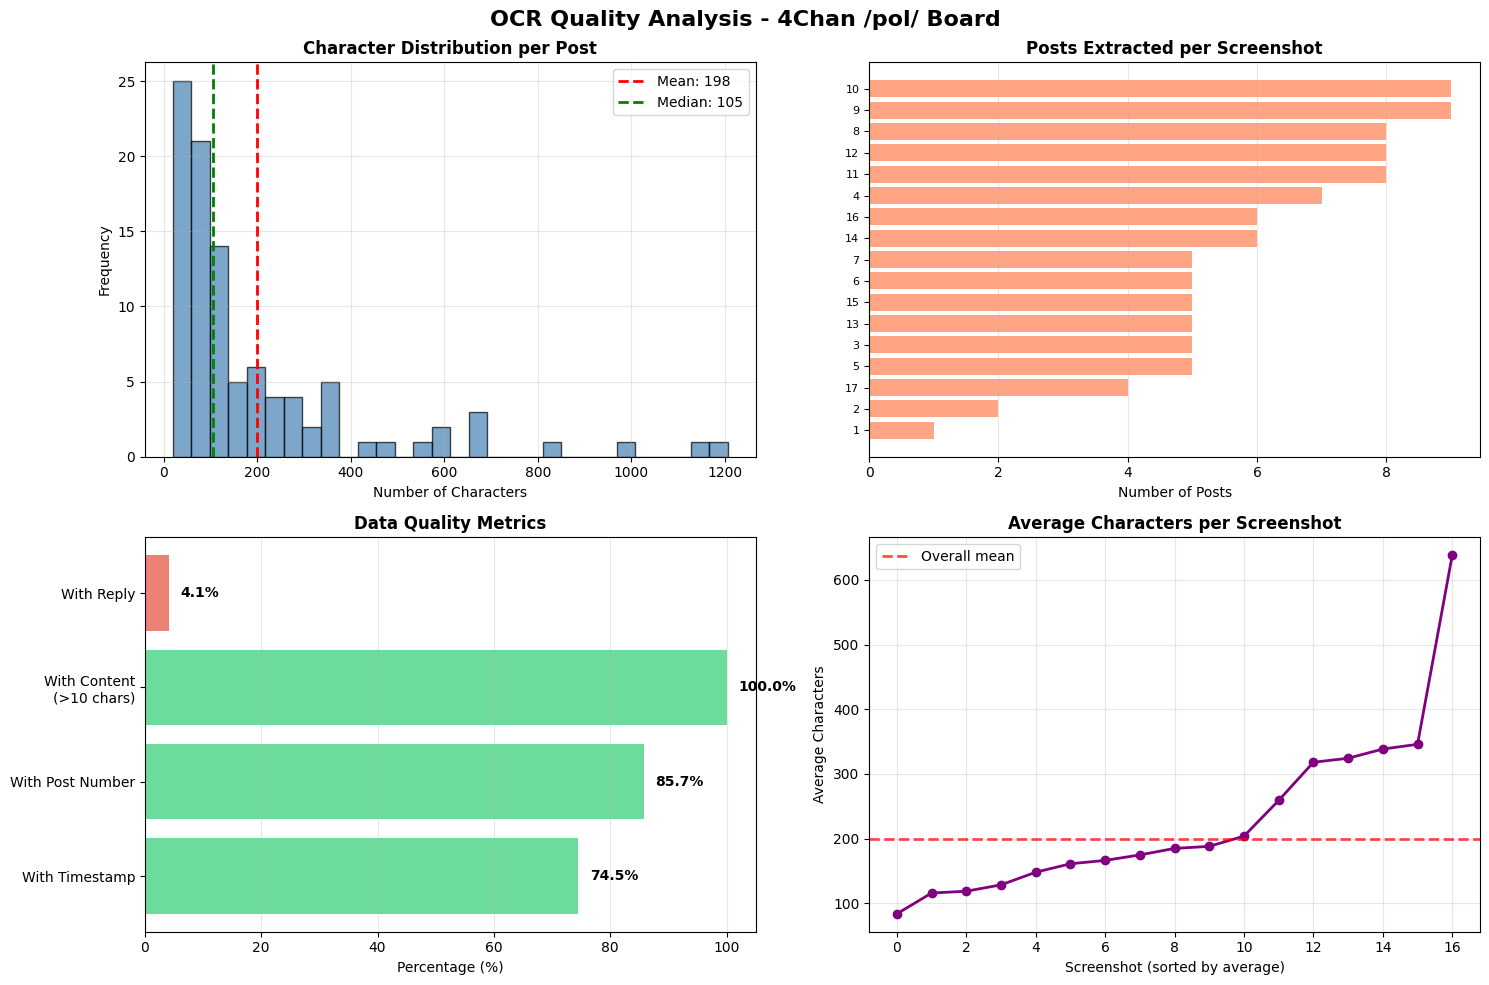


VISUAL ANALYSIS COMPLETED!

DETAILED STATISTICS:

Post size distribution:
count      98.000000
mean      198.846939
std       234.461847
min        19.000000
25%        57.500000
50%       105.000000
75%       240.250000
max      1207.000000
Name: char_count, dtype: float64

Top 5 screenshots with most posts:
screenshot_id
4chan_pol_10.png    9
4chan_pol_9.png     9
4chan_pol_8.png     8
4chan_pol_12.png    8
4chan_pol_11.png    8
dtype: int64

Top 5 longest posts:

4chan_pol_3.png (1207 chars):
   Nes Previous: >>512309367 A te DS Timeline Aug/: htips:/files.catbox.moe/m97wmg.pdt at 3 PWarnine a ...

4chan_pol_13.png (1131 chars):
   Meanwhile: A bunch of ugly niggers in their 40s are able to get college aged white woman in USA and ...

4chan_pol_17.png (985 chars):
   pacman — Alpha-gal syndrome is a type of food allergy. It makes people allergic to red meat and othe...

4chan_pol_2.png (838 chars):
   TL / eS [Reply] | rst lg E | = = — i & This board is for the discussion of news, 

In [20]:
# CELL 6: OCR QUALITY ANALYSIS WITH VISUALIZATIONS (ENGLISH VERSION)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Generating visual quality analysis")
print("")

# Load processed data
df = pd.DataFrame(processor.results)

print("Data loaded: " + str(len(df)) + " posts")
print("")

# Visualization settings
plt.style.use('default')
sns.set_palette("husl")

# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('OCR Quality Analysis - 4Chan /pol/ Board', fontsize=16, fontweight='bold')

# 1. Character distribution per post
axes[0, 0].hist(df['char_count'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('Character Distribution per Post', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Characters')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['char_count'].mean(), color='red', linestyle='--', linewidth=2,
                   label='Mean: ' + str(int(df['char_count'].mean())))
axes[0, 0].axvline(df['char_count'].median(), color='green', linestyle='--', linewidth=2,
                   label='Median: ' + str(int(df['char_count'].median())))
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Posts extracted per screenshot
posts_per_screenshot = df.groupby('screenshot_id').size().sort_values(ascending=False)
axes[0, 1].barh(range(len(posts_per_screenshot)), posts_per_screenshot.values,
                alpha=0.7, color='coral')
axes[0, 1].set_yticks(range(len(posts_per_screenshot)))
axes[0, 1].set_yticklabels([s.replace('4chan_pol_', '').replace('.png', '')
                            for s in posts_per_screenshot.index], fontsize=8)
axes[0, 1].set_title('Posts Extracted per Screenshot', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Posts')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Data quality metrics (percentage)
quality_metrics = {
    'With Timestamp': (df['timestamp'].notna().sum() / len(df)) * 100,
    'With Post Number': (df['post_number'].notna().sum() / len(df)) * 100,
    'With Content\n(>10 chars)': ((df['text_content'].str.len() > 10).sum() / len(df)) * 100,
    'With Reply': (df['reply_to'].notna().sum() / len(df)) * 100 if 'reply_to' in df else 0
}
colors = ['#2ecc71' if v > 70 else '#f39c12' if v > 50 else '#e74c3c'
          for v in quality_metrics.values()]
axes[1, 0].barh(list(quality_metrics.keys()), list(quality_metrics.values()),
                color=colors, alpha=0.7)
axes[1, 0].set_title('Data Quality Metrics', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Percentage (%)')
axes[1, 0].set_xlim(0, 105)
for i, (k, v) in enumerate(quality_metrics.items()):
    axes[1, 0].text(v + 2, i, str(round(v, 1)) + '%', va='center', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Average characters per screenshot
avg_chars = df.groupby('screenshot_id')['char_count'].mean().sort_values()
screenshot_labels = [s.replace('4chan_pol_', '').replace('.png', '') for s in avg_chars.index]
axes[1, 1].plot(avg_chars.values, marker='o', linewidth=2, markersize=6, color='purple')
axes[1, 1].set_title('Average Characters per Screenshot', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Screenshot (sorted by average)')
axes[1, 1].set_ylabel('Average Characters')
axes[1, 1].axhline(df['char_count'].mean(), color='red', linestyle='--',
                   alpha=0.7, linewidth=2, label='Overall mean')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()

# Save figure
output_path = OUTPUT_FOLDER + '/ocr_quality_analysis.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print("Figure saved at: " + output_path)

# Display figure
plt.show()

print("")
print("=" * 60)
print("VISUAL ANALYSIS COMPLETED!")
print("=" * 60)

# Additional statistics
print("\nDETAILED STATISTICS:")
print("")
print("Post size distribution:")
print(df['char_count'].describe())
print("")
print("Top 5 screenshots with most posts:")
print(posts_per_screenshot.head())
print("")
print("Top 5 longest posts:")
top_posts = df.nlargest(5, 'char_count')[['screenshot_id', 'char_count', 'text_content']]
for idx, row in top_posts.iterrows():
    print("\n" + row['screenshot_id'] + " (" + str(row['char_count']) + " chars):")
    print("   " + row['text_content'][:100] + "...")

print("\n" + "=" * 60)
print("FIGURE READY FOR ACADEMIC PUBLICATION")
print("=" * 60)

Advanced textual content analysis

Installing text analysis libraries...

Data loaded: 98 posts

1. MOST FREQUENT WORDS (with stopwords):
------------------------------------------------------------

Rank  Word            Frequency
----------------------------------------
 1.   the             103
 2.   and             76
 3.   you             44
 4.   are             36
 5.   that            27
 6.   here            21
 7.   they            19
 8.   for             17
 9.   file            17
10.   your            16
11.   what            16
12.   click           15
13.   view            15
14.   this            15
15.   can             14
16.   replies         14
17.   images          14
18.   like            13
19.   was             12
20.   will            12

2. MOST FREQUENT WORDS (without stopwords):
------------------------------------------------------------

Rank  Word            Frequency   Category
-------------------------------------------------------
 1.   file          

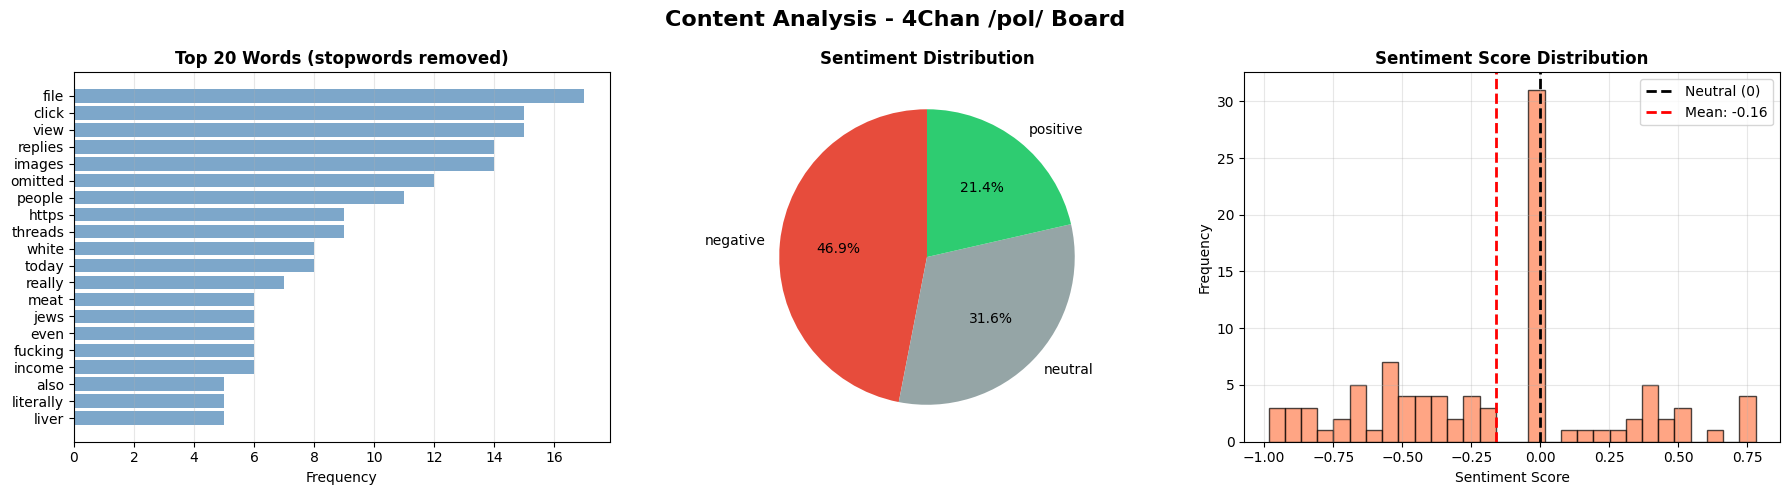


ENHANCED DATA SAVED: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Dados Processados/4chan_pol_WITH_SENTIMENT.csv

KEY FINDINGS FOR METHODOLOGY:
------------------------------------------------------------
1. Content words analyzed: 20
2. Sentiment distribution:
   - Positive: 21
   - Neutral: 31
   - Negative: 46
3. Mean sentiment: -0.161
4. Tool: VADER Sentiment Analyzer

CONTENT ANALYSIS COMPLETED!


In [25]:
# CELL 7: ADVANCED TEXTUAL CONTENT ANALYSIS (ENGLISH VERSION)

import pandas as pd
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns

print("Advanced textual content analysis")
print("=" * 60)

# Install required libraries
print("\nInstalling text analysis libraries...")
import os
os.system("pip install nltk textblob vaderSentiment --quiet --break-system-packages")

import nltk
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Download NLTK data
print("Downloading NLTK stopwords...")
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# Load data
df = pd.DataFrame(processor.results)

print("\nData loaded: " + str(len(df)) + " posts")
print("=" * 60)

# 1. MOST FREQUENT WORDS (WITH STOPWORDS)
print("\n1. MOST FREQUENT WORDS (with stopwords):")
print("-" * 60)

all_text = ' '.join(df['text_content'].fillna(''))
words_with_stop = re.findall(r'\b[a-zA-Z]{3,}\b', all_text.lower())
word_freq_with_stop = Counter(words_with_stop).most_common(20)

print("\nRank  Word            Frequency")
print("-" * 40)
for i, (word, count) in enumerate(word_freq_with_stop, 1):
    print(str(i).rjust(2) + ".   " + word.ljust(15) + " " + str(count))

# 2. MOST FREQUENT WORDS (WITHOUT STOPWORDS)
print("\n2. MOST FREQUENT WORDS (without stopwords):")
print("-" * 60)

stop_words = set(stopwords.words('english'))

additional_stops = {
    'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
    'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 'been', 'be',
    'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'should',
    'could', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those',
    'i', 'you', 'he', 'she', 'it', 'we', 'they', 'what', 'which', 'who',
    'when', 'where', 'why', 'how', 'all', 'each', 'every', 'both', 'few',
    'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only',
    'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'just', 'don',
    'now', 'get', 'like', 'know', 'think', 'see', 'make', 'go', 'take',
    'come', 'want', 'use', 'find', 'give', 'tell', 'work', 'call', 'try',
    'ask', 'need', 'feel', 'become', 'leave', 'put', 'mean', 'keep', 'let',
    'begin', 'seem', 'help', 'show', 'hear', 'play', 'run', 'move', 'live',
    'believe', 'hold', 'bring', 'happen', 'write', 'sit', 'stand', 'lose',
    'pay', 'meet', 'include', 'continue', 'set', 'learn', 'change', 'lead',
    'understand', 'watch', 'follow', 'stop', 'create', 'speak', 'read',
    'spend', 'grow', 'open', 'walk', 'win', 'offer', 'remember', 'love',
    'consider', 'appear', 'buy', 'wait', 'serve', 'die', 'send', 'expect',
    'build', 'stay', 'fall', 'cut', 'reach', 'kill', 'remain', 'suggest',
    'raise', 'pass', 'sell', 'require', 'report', 'decide', 'pull'
}

all_stops = stop_words.union(additional_stops)

words_without_stop = [w for w in words_with_stop if w not in all_stops and len(w) > 3]
word_freq_without_stop = Counter(words_without_stop).most_common(20)

print("\nRank  Word            Frequency   Category")
print("-" * 55)
for i, (word, count) in enumerate(word_freq_without_stop, 1):
    if word in ['trump', 'biden', 'president', 'government', 'political', 'election']:
        category = "Politics"
    elif word in ['people', 'society', 'social', 'community', 'group']:
        category = "Social"
    elif word in ['time', 'year', 'day', 'today', 'now']:
        category = "Temporal"
    else:
        category = "Content"

    print(str(i).rjust(2) + ".   " + word.ljust(15) + " " + str(count).rjust(5) + "     " + category)

# 3. SENTIMENT ANALYSIS
print("\n3. SENTIMENT ANALYSIS:")
print("-" * 60)

analyzer = SentimentIntensityAnalyzer()

sentiments = []
for text in df['text_content'].fillna(''):
    if len(text) > 10:
        vader_scores = analyzer.polarity_scores(text)

        if vader_scores['compound'] >= 0.05:
            sentiment = 'positive'
        elif vader_scores['compound'] <= -0.05:
            sentiment = 'negative'
        else:
            sentiment = 'neutral'

        sentiments.append({
            'sentiment': sentiment,
            'compound': vader_scores['compound'],
            'positive': vader_scores['pos'],
            'negative': vader_scores['neg'],
            'neutral': vader_scores['neu']
        })
    else:
        sentiments.append({
            'sentiment': 'neutral',
            'compound': 0,
            'positive': 0,
            'negative': 0,
            'neutral': 1
        })

df_sentiment = pd.DataFrame(sentiments)
df['sentiment'] = df_sentiment['sentiment']
df['sentiment_score'] = df_sentiment['compound']
df['sentiment_positive'] = df_sentiment['positive']
df['sentiment_negative'] = df_sentiment['negative']
df['sentiment_neutral'] = df_sentiment['neutral']

print("\nSENTIMENT DISTRIBUTION:")
sentiment_counts = df['sentiment'].value_counts()
total = len(df)

print("\nSentiment    Count    Percentage")
print("-" * 40)
for sent in ['positive', 'neutral', 'negative']:
    if sent in sentiment_counts.index:
        count = sentiment_counts[sent]
        pct = round(count/total*100, 1)
        print(sent.capitalize().ljust(12) + str(count).rjust(5) + "    " + str(pct) + "%")

print("\nSENTIMENT SCORE STATISTICS:")
print("-" * 40)
print("Mean compound score: " + str(round(df['sentiment_score'].mean(), 3)))
print("Median compound score: " + str(round(df['sentiment_score'].median(), 3)))
print("Std deviation: " + str(round(df['sentiment_score'].std(), 3)))

print("\nMOST POSITIVE POSTS:")
print("-" * 60)
most_positive = df.nlargest(3, 'sentiment_score')[['screenshot_id', 'sentiment_score', 'text_content']]
for idx, row in most_positive.iterrows():
    print("\nScore: " + str(round(row['sentiment_score'], 3)) + " | " + row['screenshot_id'])
    print("Text: " + row['text_content'][:120] + "...")

print("\nMOST NEGATIVE POSTS:")
print("-" * 60)
most_negative = df.nsmallest(3, 'sentiment_score')[['screenshot_id', 'sentiment_score', 'text_content']]
for idx, row in most_negative.iterrows():
    print("\nScore: " + str(round(row['sentiment_score'], 3)) + " | " + row['screenshot_id'])
    print("Text: " + row['text_content'][:120] + "...")

# 4. VISUALIZATIONS
print("\n" + "=" * 60)
print("GENERATING VISUALIZATIONS...")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Content Analysis - 4Chan /pol/ Board', fontsize=16, fontweight='bold')

words_plot = [w[0] for w in word_freq_without_stop[:20]]
counts_plot = [w[1] for w in word_freq_without_stop[:20]]

axes[0].barh(range(len(words_plot)), counts_plot, color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(words_plot)))
axes[0].set_yticklabels(words_plot)
axes[0].invert_yaxis()
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 20 Words (stopwords removed)', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

sentiment_data = df['sentiment'].value_counts()
colors_pie = {'positive': '#2ecc71', 'neutral': '#95a5a6', 'negative': '#e74c3c'}
colors_list = [colors_pie.get(sent, '#95a5a6') for sent in sentiment_data.index]

axes[1].pie(sentiment_data.values, labels=sentiment_data.index, autopct='%1.1f%%',
            colors=colors_list, startangle=90)
axes[1].set_title('Sentiment Distribution', fontweight='bold')

axes[2].hist(df['sentiment_score'], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[2].axvline(0, color='black', linestyle='--', linewidth=2, label='Neutral (0)')
axes[2].axvline(df['sentiment_score'].mean(), color='red', linestyle='--',
                linewidth=2, label='Mean: ' + str(round(df['sentiment_score'].mean(), 2)))
axes[2].set_xlabel('Sentiment Score')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Sentiment Score Distribution', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()

output_path = OUTPUT_FOLDER + '/content_sentiment_analysis.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print("\nFigure saved at: " + output_path)

plt.show()

# 5. SAVE ENHANCED DATA
enhanced_path = OUTPUT_FOLDER + '/4chan_pol_WITH_SENTIMENT.csv'
df.to_csv(enhanced_path, index=False, encoding='utf-8')

print("\n" + "=" * 60)
print("ENHANCED DATA SAVED: " + enhanced_path)
print("=" * 60)

print("\nKEY FINDINGS FOR METHODOLOGY:")
print("-" * 60)
print("1. Content words analyzed: " + str(len(word_freq_without_stop)))
print("2. Sentiment distribution:")
print("   - Positive: " + str(sentiment_counts.get('positive', 0)))
print("   - Neutral: " + str(sentiment_counts.get('neutral', 0)))
print("   - Negative: " + str(sentiment_counts.get('negative', 0)))
print("3. Mean sentiment: " + str(round(df['sentiment_score'].mean(), 3)))
print("4. Tool: VADER Sentiment Analyzer")

print("\n" + "=" * 60)
print("CONTENT ANALYSIS COMPLETED!")
print("=" * 60)

Complete Content Analysis - Text + Images

Installing required libraries...

Data loaded: 98 posts from 17 screenshots

PART 1: TEXT ANALYSIS

Top 20 Words (stopwords removed):
--------------------------------------------------
 1. file                17
 2. click               15
 3. view                15
 4. replies             14
 5. images              14
 6. omitted             12
 7. people              11
 8. https               9
 9. threads             9
10. white               8
11. today               8
12. really              7
13. meat                6
14. jews                6
15. even                6
16. come                6
17. fucking             6
18. income              6
19. also                5
20. literally           5

Analyzing text sentiment...

Text Sentiment Distribution:
  Positive: 21 (21.4%)
  Neutral: 31 (31.6%)
  Negative: 46 (46.9%)

PART 2: IMAGE ANALYSIS

Loading CLIP model...
CLIP loaded

Processing 17 screenshots...
  [1/17] 4chan_pol_1.png
  [2

/tmp/ipython-input-2984455359.py:303: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Figure saved: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Dados Processados/complete_multimodal_analysis.png


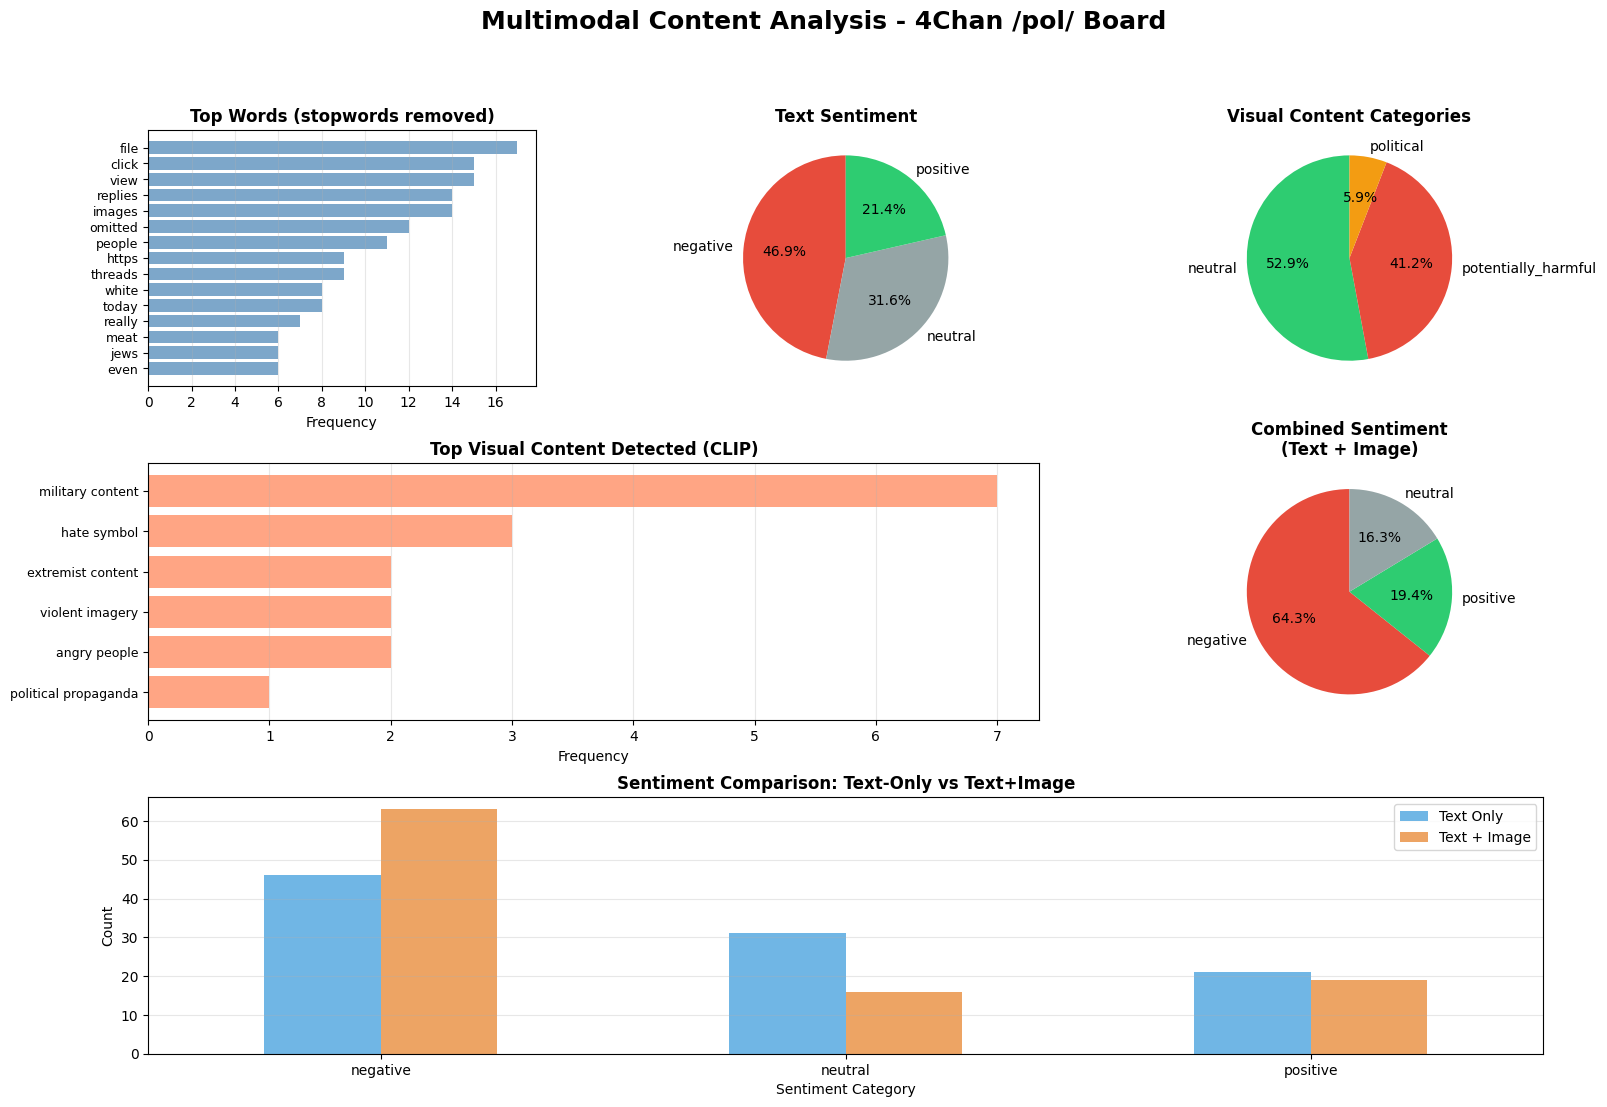


MULTIMODAL ANALYSIS COMPLETED!

FINAL STATISTICS:
------------------------------------------------------------
Posts analyzed: 98
Screenshots: 17

Visual Content:
  neutral: 9 (52.9%)
  potentially_harmful: 7 (41.2%)
  political: 1 (5.9%)

Combined Sentiment:
  Negative: 63 (64.3%)
  Positive: 19 (19.4%)
  Neutral: 16 (16.3%)

Image Impact on Sentiment:
  Mean shift: -0.121

File saved: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Dados Processados/4chan_pol_MULTIMODAL_ANALYSIS.csv


In [28]:
# CELL 7: COMPLETE TEXT + IMAGE ANALYSIS (COMBINED)

import pandas as pd
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import numpy as np

print("Complete Content Analysis - Text + Images")
print("=" * 60)

# Install libraries
print("\nInstalling required libraries...")
os.system("pip install nltk vaderSentiment torch torchvision transformers --quiet --break-system-packages")

import nltk
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import torch
from transformers import CLIPProcessor, CLIPModel, pipeline

# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# Load data
df = pd.DataFrame(processor.results)

print("\nData loaded: " + str(len(df)) + " posts from " + str(df['screenshot_id'].nunique()) + " screenshots")
print("")

# ================================================================
# PART 1: TEXT ANALYSIS
# ================================================================

print("=" * 60)
print("PART 1: TEXT ANALYSIS")
print("=" * 60)

# 1A. Words WITH stopwords
all_text = ' '.join(df['text_content'].fillna(''))
words_with_stop = re.findall(r'\b[a-zA-Z]{3,}\b', all_text.lower())
word_freq_with_stop = Counter(words_with_stop).most_common(20)

# 1B. Words WITHOUT stopwords
stop_words = set(stopwords.words('english'))
additional_stops = {
    'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
    'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 'been', 'be',
    'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'should',
    'could', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those',
    'i', 'you', 'he', 'she', 'it', 'we', 'they', 'what', 'which', 'who',
    'just', 'get', 'like', 'know', 'think', 'see', 'make', 'go', 'now'
}
all_stops = stop_words.union(additional_stops)
words_without_stop = [w for w in words_with_stop if w not in all_stops and len(w) > 3]
word_freq_without_stop = Counter(words_without_stop).most_common(20)

print("\nTop 20 Words (stopwords removed):")
print("-" * 50)
for i, (word, count) in enumerate(word_freq_without_stop, 1):
    print(str(i).rjust(2) + ". " + word.ljust(20) + str(count))

# 1C. Text Sentiment Analysis
print("\nAnalyzing text sentiment...")
analyzer = SentimentIntensityAnalyzer()

sentiments = []
for text in df['text_content'].fillna(''):
    if len(text) > 10:
        vader_scores = analyzer.polarity_scores(text)
        if vader_scores['compound'] >= 0.05:
            sentiment = 'positive'
        elif vader_scores['compound'] <= -0.05:
            sentiment = 'negative'
        else:
            sentiment = 'neutral'
        sentiments.append({
            'sentiment': sentiment,
            'compound': vader_scores['compound'],
            'positive': vader_scores['pos'],
            'negative': vader_scores['neg'],
            'neutral': vader_scores['neu']
        })
    else:
        sentiments.append({
            'sentiment': 'neutral',
            'compound': 0,
            'positive': 0,
            'negative': 0,
            'neutral': 1
        })

df_sentiment = pd.DataFrame(sentiments)
df['text_sentiment'] = df_sentiment['sentiment']
df['text_sentiment_score'] = df_sentiment['compound']

print("\nText Sentiment Distribution:")
text_sent_counts = df['text_sentiment'].value_counts()
for sent in ['positive', 'neutral', 'negative']:
    if sent in text_sent_counts.index:
        count = text_sent_counts[sent]
        pct = round(count/len(df)*100, 1)
        print("  " + sent.capitalize() + ": " + str(count) + " (" + str(pct) + "%)")

# ================================================================
# PART 2: IMAGE ANALYSIS
# ================================================================

print("\n" + "=" * 60)
print("PART 2: IMAGE ANALYSIS")
print("=" * 60)

# Load models
print("\nLoading CLIP model...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print("CLIP loaded")

content_categories = [
    "political propaganda", "political meme", "protest", "flag or symbol",
    "angry people", "violent imagery", "weapon or gun", "military content",
    "hate symbol", "extremist content",
    "peaceful scene", "nature or landscape", "normal conversation", "humor or joke"
]

screenshots = df['screenshot_id'].unique()
image_results = []

print("\nProcessing " + str(len(screenshots)) + " screenshots...")

for i, screenshot_file in enumerate(screenshots, 1):
    print("  [" + str(i) + "/" + str(len(screenshots)) + "] " + screenshot_file)

    image_path = os.path.join(SCREENSHOTS_FOLDER, screenshot_file)

    try:
        image = Image.open(image_path).convert('RGB')

        result = {'screenshot_id': screenshot_file}

        inputs = clip_processor(text=content_categories, images=image,
                               return_tensors="pt", padding=True)

        with torch.no_grad():
            outputs = clip_model(**inputs)
            probs = outputs.logits_per_image.softmax(dim=1)

        top_probs, top_indices = torch.topk(probs[0], 3)

        result['visual_category_1'] = content_categories[top_indices[0]]
        result['visual_score_1'] = float(top_probs[0])

        top_cat = result['visual_category_1']
        if any(term in top_cat for term in ['violent', 'weapon', 'gun', 'hate', 'extremist']):
            result['visual_class'] = 'potentially_harmful'
        elif any(term in top_cat for term in ['political', 'propaganda', 'protest', 'flag']):
            result['visual_class'] = 'political'
        else:
            result['visual_class'] = 'neutral'

        image_results.append(result)

    except Exception as e:
        print("    ERROR: " + str(e))
        image_results.append({
            'screenshot_id': screenshot_file,
            'visual_class': 'error'
        })

df_images = pd.DataFrame(image_results)

print("\nVisual Content Distribution:")
visual_counts = df_images['visual_class'].value_counts()
for cat, count in visual_counts.items():
    pct = round(count/len(df_images)*100, 1)
    print("  " + cat + ": " + str(count) + " (" + str(pct) + "%)")

# ================================================================
# PART 3: COMBINE TEXT + IMAGE
# ================================================================

print("\n" + "=" * 60)
print("PART 3: COMBINED ANALYSIS")
print("=" * 60)

df_combined = df.merge(df_images, on='screenshot_id', how='left')

def calc_combined_sentiment(row):
    text_score = row.get('text_sentiment_score', 0)
    visual = row.get('visual_class', 'neutral')

    if visual == 'potentially_harmful':
        combined = min(text_score - 0.3, text_score)
    elif visual == 'political':
        combined = text_score * 1.2 if abs(text_score) > 0.1 else text_score
    else:
        combined = text_score

    return max(-1, min(1, combined))

df_combined['combined_sentiment_score'] = df_combined.apply(calc_combined_sentiment, axis=1)
df_combined['combined_sentiment'] = df_combined['combined_sentiment_score'].apply(
    lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral')
)

print("\nCombined Sentiment (Text + Image):")
combined_counts = df_combined['combined_sentiment'].value_counts()
for sent in ['positive', 'neutral', 'negative']:
    if sent in combined_counts.index:
        count = combined_counts[sent]
        pct = round(count/len(df_combined)*100, 1)
        print("  " + sent.capitalize() + ": " + str(count) + " (" + str(pct) + "%)")

print("\nSentiment Score Comparison:")
print("  Text-only mean: " + str(round(df_combined['text_sentiment_score'].mean(), 3)))
print("  Combined mean: " + str(round(df_combined['combined_sentiment_score'].mean(), 3)))
print("  Image impact: " + str(round(df_combined['combined_sentiment_score'].mean() -
                                     df_combined['text_sentiment_score'].mean(), 3)))

# ================================================================
# PART 4: VISUALIZATIONS
# ================================================================

print("\n" + "=" * 60)
print("GENERATING VISUALIZATIONS")
print("=" * 60)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

fig.suptitle('Multimodal Content Analysis - 4Chan /pol/ Board',
             fontsize=18, fontweight='bold')

# 1. Top words (no stopwords)
ax1 = fig.add_subplot(gs[0, 0])
words = [w[0] for w in word_freq_without_stop[:15]]
counts = [w[1] for w in word_freq_without_stop[:15]]
ax1.barh(range(len(words)), counts, color='steelblue', alpha=0.7)
ax1.set_yticks(range(len(words)))
ax1.set_yticklabels(words, fontsize=9)
ax1.invert_yaxis()
ax1.set_xlabel('Frequency')
ax1.set_title('Top Words (stopwords removed)', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# 2. Text sentiment
ax2 = fig.add_subplot(gs[0, 1])
colors_sent = {'positive': '#2ecc71', 'neutral': '#95a5a6', 'negative': '#e74c3c'}
text_sent_data = df['text_sentiment'].value_counts()
colors = [colors_sent.get(s, '#95a5a6') for s in text_sent_data.index]
ax2.pie(text_sent_data.values, labels=text_sent_data.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax2.set_title('Text Sentiment', fontweight='bold')

# 3. Visual content categories
ax3 = fig.add_subplot(gs[0, 2])
colors_vis = {'potentially_harmful': '#e74c3c', 'political': '#f39c12',
              'neutral': '#2ecc71', 'error': '#95a5a6'}
visual_data = df_images['visual_class'].value_counts()
colors_v = [colors_vis.get(v, '#95a5a6') for v in visual_data.index]
ax3.pie(visual_data.values, labels=visual_data.index, autopct='%1.1f%%',
        colors=colors_v, startangle=90)
ax3.set_title('Visual Content Categories', fontweight='bold')

# 4. Top visual content
ax4 = fig.add_subplot(gs[1, :2])
if 'visual_category_1' in df_images.columns:
    vis_top = df_images['visual_category_1'].value_counts().head(10)
    ax4.barh(range(len(vis_top)), vis_top.values, color='coral', alpha=0.7)
    ax4.set_yticks(range(len(vis_top)))
    ax4.set_yticklabels(vis_top.index, fontsize=9)
    ax4.invert_yaxis()
    ax4.set_xlabel('Frequency')
    ax4.set_title('Top Visual Content Detected (CLIP)', fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')

# 5. Combined sentiment
ax5 = fig.add_subplot(gs[1, 2])
combined_data = df_combined['combined_sentiment'].value_counts()
colors_c = [colors_sent.get(s, '#95a5a6') for s in combined_data.index]
ax5.pie(combined_data.values, labels=combined_data.index, autopct='%1.1f%%',
        colors=colors_c, startangle=90)
ax5.set_title('Combined Sentiment\n(Text + Image)', fontweight='bold')

# 6. Sentiment comparison
ax6 = fig.add_subplot(gs[2, :])
comparison_data = pd.DataFrame({
    'Text Only': df_combined['text_sentiment'].value_counts(),
    'Text + Image': df_combined['combined_sentiment'].value_counts()
})
comparison_data.plot(kind='bar', ax=ax6, color=['#3498db', '#e67e22'], alpha=0.7)
ax6.set_title('Sentiment Comparison: Text-Only vs Text+Image', fontweight='bold', fontsize=12)
ax6.set_xlabel('Sentiment Category')
ax6.set_ylabel('Count')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=0)

plt.tight_layout()

output_path = OUTPUT_FOLDER + '/complete_multimodal_analysis.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print("\nFigure saved: " + output_path)

plt.show()

# ================================================================
# SAVE RESULTS
# ================================================================

output_combined = OUTPUT_FOLDER + '/4chan_pol_MULTIMODAL_ANALYSIS.csv'
df_combined.to_csv(output_combined, index=False, encoding='utf-8')

print("\n" + "=" * 60)
print("MULTIMODAL ANALYSIS COMPLETED!")
print("=" * 60)

print("\nFINAL STATISTICS:")
print("-" * 60)
print("Posts analyzed: " + str(len(df)))
print("Screenshots: " + str(len(df_images)))
print("")
print("Visual Content:")
for cat, count in visual_counts.items():
    pct = round(count/len(df_images)*100, 1)
    print("  " + cat + ": " + str(count) + " (" + str(pct) + "%)")
print("")
print("Combined Sentiment:")
for sent, count in combined_counts.items():
    pct = round(count/len(df_combined)*100, 1)
    print("  " + sent.capitalize() + ": " + str(count) + " (" + str(pct) + "%)")
print("")
print("Image Impact on Sentiment:")
print("  Mean shift: " + str(round(df_combined['combined_sentiment_score'].mean() -
                                   df_combined['text_sentiment_score'].mean(), 3)))

print("\nFile saved: " + output_combined)
print("=" * 60)

In [26]:
# CELL 8: PREPARE DATA FOR STATISTICAL ANALYSIS (ENGLISH VERSION)

import pandas as pd

print("Preparing data for statistical analysis")
print("")

# Load data
df = pd.DataFrame(processor.results)

# Create clean version for analysis
df_clean = df.copy()

# Remove empty posts
df_clean = df_clean[df_clean['text_content'].str.len() > 10]

# Add useful columns
df_clean['word_count'] = df_clean['text_content'].str.split().str.len()
df_clean['has_timestamp'] = df_clean['timestamp'].notna()
df_clean['has_post_number'] = df_clean['post_number'].notna()
df_clean['has_reply'] = df_clean['reply_to'].notna() if 'reply_to' in df_clean else False

# Add post length categories
df_clean['length_category'] = pd.cut(df_clean['char_count'],
                                      bins=[0, 50, 150, 300, float('inf')],
                                      labels=['short', 'medium', 'long', 'very_long'])

# Summary statistics
print("CLEAN DATASET SUMMARY:")
print("=" * 60)
print("   Total posts extracted: " + str(len(df)))
print("   Valid posts (>10 chars): " + str(len(df_clean)))
print("   Posts removed: " + str(len(df) - len(df_clean)))
print("   Retention rate: " + str(round(len(df_clean)/len(df)*100, 1)) + "%")

print("\nDATA QUALITY METRICS:")
print("-" * 60)
print("   Posts with timestamp: " + str(df_clean['has_timestamp'].sum()) +
      " (" + str(round(df_clean['has_timestamp'].sum()/len(df_clean)*100, 1)) + "%)")
print("   Posts with post number: " + str(df_clean['has_post_number'].sum()) +
      " (" + str(round(df_clean['has_post_number'].sum()/len(df_clean)*100, 1)) + "%)")
print("   Posts with reply: " + str(df_clean['has_reply'].sum()) +
      " (" + str(round(df_clean['has_reply'].sum()/len(df_clean)*100, 1)) + "%)")

print("\nTEXT STATISTICS:")
print("-" * 60)
print("   Mean characters per post: " + str(round(df_clean['char_count'].mean(), 1)))
print("   Median characters per post: " + str(round(df_clean['char_count'].median(), 1)))
print("   Mean words per post: " + str(round(df_clean['word_count'].mean(), 1)))
print("   Total words extracted: " + str(df_clean['word_count'].sum()))

# Save clean version
clean_path = OUTPUT_FOLDER + '/4chan_pol_CLEAN.csv'
df_clean.to_csv(clean_path, index=False, encoding='utf-8')

print("\nCLEAN FILE SAVED:")
print("   " + clean_path)

print("\nAVAILABLE COLUMNS FOR ANALYSIS:")
print("-" * 60)
for i, col in enumerate(df_clean.columns, 1):
    dtype = str(df_clean[col].dtype)
    print("   " + str(i).rjust(2) + ". " + col.ljust(20) + " (" + dtype + ")")

print("\n" + "=" * 60)
print("DATA READY FOR:")
print("   - R / Python statistical analysis")
print("   - SPSS / Stata")
print("   - NVivo / ATLAS.ti (qualitative)")
print("   - Network analysis (Gephi, igraph)")
print("=" * 60)

Preparing data for statistical analysis

CLEAN DATASET SUMMARY:
   Total posts extracted: 98
   Valid posts (>10 chars): 98
   Posts removed: 0
   Retention rate: 100.0%

DATA QUALITY METRICS:
------------------------------------------------------------
   Posts with timestamp: 73 (74.5%)
   Posts with post number: 84 (85.7%)
   Posts with reply: 4 (4.1%)

TEXT STATISTICS:
------------------------------------------------------------
   Mean characters per post: 198.8
   Median characters per post: 105.0
   Mean words per post: 34.1
   Total words extracted: 3338

CLEAN FILE SAVED:
   /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Dados Processados/4chan_pol_CLEAN.csv

AVAILABLE COLUMNS FOR ANALYSIS:
------------------------------------------------------------
    1. user                 (object)
    2. post_number          (object)
    3. text_content         (object)
    4. timestamp            (object)
    5. has_image            (bool)
    6. reply_to             (object)
 